# Система детекции реальных тревог электросамокатов

## Описание проекта

Данный проект направлен на улучшение существующего алгоритма оценки тревог для электросамокатов с помощью модели машинного обучения. Текущая система оценки тревог имеет недостатки: ложные тревоги часто получают завышенные оценки, а реальные тревоги (например, случаи кражи) - заниженные.

Цель проекта - обучить модель машинного обучения, которая будет более точно предсказывать вероятность того, что тревога является реальной, в диапазоне от 0 до 100%.

## Данные

Набор данных содержит информацию о различных инцидентах с электросамокатами. Каждая строка соответствует одному инциденту.

### Структура данных

| Признак | Описание |
|---------|----------|
| incident_id | Уникальный идентификатор инцидента |
| probability | Текущая вероятность тревоги (от 0 до 100%) |
| is_real_incident | Целевая переменная: 1 - реальная тревога, 0 - ложная тревога |
| last_order_end | Дата и время окончания последнего заказа |
| after_order_start | Дата и время начала периода afterOrder |
| gap_minutes | Разница между last_order_end и after_order_start (мин.) |
| total_after_distance_km | Общая дистанция afterOrderTrack (км) |
| max_jump_distance_km | Максимальный скачок координат (GPS-глюк), км |
| mean_speed_kmh | Средняя скорость движения (км/ч) |
| median_speed_kmh | Медианная скорость движения (км/ч) |
| max_speed_kmh | Максимальная скорость движения (км/ч) |
| bearing_changes | Количество резких поворотов (>150°) |
| static_segments_ratio | Доля статичных сегментов (скорость < 1 км/ч) |
| radius_from_start_m | Максимальный радиус перемещения от начальной точки (м) |
| coordinate_stability_m | Среднее стандартное отклонение координат (GPS-дрейф, м) |
| return_count | Количество циклических возвратов к стартовой точке |
| after_order_start_hour | Час начала afterOrder (0-23) |
| after_track_duration_minutes | Продолжительность afterOrderTrack (мин.) |
| bearing_changes_ratio | Доля резких поворотов к общему числу сегментов |
| full_stop_count | Количество остановок (>1 мин, скорость <1 км/ч) |
| linearity | Линейность траектории движения |

## Основные этапы проекта

1. **Подготовка данных и EDA**
   - Обработка пропущенных значений и выбросов
   - Анализ распределений признаков
   - Выявление корреляций между признаками
   - Визуализация ключевых зависимостей

2. **Предобработка данных**
   - Трансформация признаков (логарифмирование, масштабирование)
   - Обработка временных признаков
   - Генерация новых признаков


In [ ]:
# Exploratory Data Analysis для проекта по оценке тревог электросамокатов
# Импорт необходимых библиотек

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier


# Настройка отображения
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
pd.set_option('display.max_columns', None)
sns.set(font_scale=1.2)

# 1. Загрузка данных
print("1. Загрузка данных")
df = pd.read_csv('/content/incidents_with_features.csv')


1. Загрузка данных


# New Section

In [ ]:
df.head(20)

,incident_id,probability,is_real_incident,last_order_end,after_order_start,gap_minutes,total_after_distance_km,max_jump_distance_km,mean_speed_kmh,median_speed_kmh,max_speed_kmh,bearing_changes,static_segments_ratio,radius_from_start_m,coordinate_stability_m,return_count,after_order_start_hour,after_track_duration_minutes,bearing_changes_ratio,full_stop_count,alarm_id,tracker_id,business_status,status,timestamp
0,1,0,1,2025-02-10 23:59:10.386000,2025-02-11 07:18:32.237000,439.364183,0.090702,0.008636,0.094053,0.071359,0.257625,7,1.000000,11.168542,4.109400,28,7,57.789367,0.250000,29,S.261817,8.67255E+14,Investigation,correct,2025-02-12T13:34:36.605443
1,2,25,1,2025-01-31 11:45:31.325000,2025-02-07 14:49:03.351000,10263.533767,0.244380,0.075764,0.274677,0.075675,2.706878,4,0.931034,174.352475,36.158442,26,14,57.356167,0.142857,27,NaN,NaN,Investigation,correct,2025-02-12T13:48:59.576441
2,3,0,1,2025-02-05 15:13:39.682000,2025-02-07 14:49:18.774000,2855.651533,0.012677,0.000837,0.013495,0.012385,0.033622,3,1.000000,2.335114,1.028942,33,14,58.778617,0.090909,34,NaN,NaN,Investigation,pending,2025-02-12T13:54:48.956798
3,5,25,0,2025-02-07 14:03:41.886000,2025-02-07 14:50:25.141000,46.720917,0.314775,0.048184,0.328790,0.209402,0.951281,7,1.000000,38.099076,17.810197,18,14,57.557250,0.388889,19,NaN,NaN,Operation,pending,2025-02-12T14:11:13.078619
4,6,25,1,2025-02-10 11:29:07.917000,2025-02-11 07:19:02.423000,1189.908433,0.398387,0.091220,0.399110,0.288976,1.841314,1,0.950000,256.459377,120.382694,10,7,57.034533,0.052632,18,S.172186,867648045765664,Investigation,pending,2025-02-12T14:23:14.402509
5,7,35,1,2025-02-03 06:58:03.642000,2025-02-07 14:50:09.922000,6232.104667,0.513424,0.124318,0.563411,0.055175,4.199936,6,0.827586,414.106316,100.086563,24,14,57.422300,0.214286,24,NaN,NaN,Investigation,correct,2025-02-12T14:52:10.350276
6,8,45,0,2025-02-07 05:46:19.530000,2025-02-07 14:48:53.749000,542.570317,22.475853,22.460824,21.454133,0.000000,664.625195,1,0.967742,22460.823835,9602.854250,6,14,58.187983,0.032258,27,NaN,NaN,Operation,mistaken,2025-02-12T14:53:20.794639
7,9,0,1,2025-02-05 21:39:04.766000,2025-02-11 07:37:09.384000,7798.076967,0.037839,0.003697,0.039241,0.036789,0.108693,5,1.000000,3.879052,1.491903,28,7,58.000033,0.178571,29,S.502896,8.67255E+14,Investigation,pending,2025-02-12T14:54:11.174292
8,10,25,1,2025-02-10 11:29:07.917000,2025-02-11 07:19:02.423000,1189.908433,0.398387,0.091220,0.399110,0.288976,1.841314,1,0.950000,256.459377,120.382694,10,7,57.034533,0.052632,18,S.172186,867648045765664,Investigation,pending,2025-02-12T19:08:23.268816
9,11,25,1,2025-02-10 11:29:07.917000,2025-02-11 07:19:02.423000,1189.908433,0.398387,0.091220,0.399110,0.288976,1.841314,1,0.950000,256.459377,120.382694,10,7,57.034533,0.052632,18,S.172186,867648045765664,Investigation,pending,2025-02-12T19:08:39.354141


In [ ]:
# Информация о датасете
print("\nОбщая информация о датасете:")
df.info()


Общая информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44494 entries, 0 to 44493
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   incident_id                   44494 non-null  int64  
 1   probability                   44494 non-null  int64  
 2   is_real_incident              44494 non-null  int64  
 3   last_order_end                44494 non-null  object 
 4   after_order_start             44494 non-null  object 
 5   gap_minutes                   44494 non-null  float64
 6   total_after_distance_km       44494 non-null  float64
 7   max_jump_distance_km          44494 non-null  float64
 8   mean_speed_kmh                44494 non-null  float64
 9   median_speed_kmh              44494 non-null  float64
 10  max_speed_kmh                 44494 non-null  float64
 11  bearing_changes               44494 non-null  int64  
 12  static_segments_ratio         

In [ ]:
# Проверка целевой переменной
print("\nРаспределение целевой переменной:")
print(df['is_real_incident'].value_counts())
print(df['is_real_incident'].value_counts(normalize=True).map(lambda x: f"{x:.2%}"))


Распределение целевой переменной:
is_real_incident
0    39333
1     5161
Name: count, dtype: int64
is_real_incident
0    88.40%
1    11.60%
Name: proportion, dtype: object


In [ ]:
# Статистика по числовым столбцам
print("\nСтатистика по числовым признакам:")
df.describe().T


Статистика по числовым признакам:


,count,mean,std,min,25%,50%,75%,max
incident_id,5938.0,2.213511e+04,2.109704e+03,1.816100e+04,2.048625e+04,2.219250e+04,2.393575e+04,2.574400e+04
probability,5938.0,1.967666e+01,2.883067e+01,0.000000e+00,0.000000e+00,0.000000e+00,4.500000e+01,7.500000e+01
is_real_incident,5938.0,9.767599e-02,2.969010e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
gap_minutes,5938.0,1.064618e+09,1.247905e+03,1.064614e+09,1.064617e+09,1.064618e+09,1.064619e+09,1.064621e+09
total_after_distance_km,5938.0,5.375512e+02,2.376513e+03,0.000000e+00,2.072500e-01,3.317500e+00,2.350772e+02,7.765309e+04
max_jump_distance_km,5938.0,6.396634e+01,5.663680e+02,0.000000e+00,8.100000e-02,8.390000e-01,3.049300e+01,8.347678e+03
mean_speed_kmh,5938.0,5.146006e+03,1.710007e+05,0.000000e+00,2.600000e-01,3.780000e+00,9.459250e+01,7.981810e+06
median_speed_kmh,5938.0,8.877336e+01,4.105047e+03,0.000000e+00,0.000000e+00,3.000000e-02,2.142500e+00,2.815385e+05
max_speed_kmh,5938.0,4.342568e+05,1.928209e+07,0.000000e+00,7.815000e+00,5.948500e+01,1.490990e+03,1.251772e+09
bearing_changes,5938.0,2.553857e+01,4.342060e+01,0.000000e+00,1.000000e+00,7.000000e+00,3.100000e+01,4.560000e+02


In [ ]:
df['after_order_start'].isnull().sum()

np.int64(0)

In [ ]:
# 3. Обработка пропущенных значений
print("\n3. Обработка пропущенных значений")

# Проверка пропусков
print("\nКоличество пропущенных значений по столбцам:")
missing_values = df.isnull().sum()
missing_percent = (df.isnull().sum() / len(df)) * 100
missing_df = pd.DataFrame({'missing_values': missing_values,
                          'percent_missing': missing_percent.round(2)})
print(missing_df[missing_df['missing_values'] > 0])



3. Обработка пропущенных значений

Количество пропущенных значений по столбцам:
Empty DataFrame
Columns: [missing_values, percent_missing]
Index: []


In [ ]:
# Если есть пропуски, заполним их
if missing_df['missing_values'].sum() > 0:
    # Числовые признаки заполняем медианой
    numeric_cols = df.select_dtypes(include=['number']).columns
    for col in numeric_cols:
        if df[col].isnull().sum() > 0:
            median_value = df[col].median()
            df[col].fillna(median_value, inplace=True)
            print(f"Заполнили пропуски в столбце {col} медианным значением: {median_value}")

In [ ]:
# 4. Обработка временных признаков
print("\n4. Обработка временных признаков")

# Преобразование временных столбцов
date_columns = ['last_order_end', 'after_order_start']
for col in date_columns:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')




4. Обработка временных признаков


In [ ]:
# Проверяем корректные даты
print("\nПроверка дат last_order_end:")
print(df['last_order_end'].describe())



Проверка дат last_order_end:
count      0
mean     NaT
min      NaT
25%      NaT
50%      NaT
75%      NaT
max      NaT
Name: last_order_end, dtype: object


In [ ]:
# Если 0001-01-01 встречается часто, возможно это требует специальной обработки
invalid_dates = pd.isna(df['last_order_end']).shape[0]
print(f"\nКоличество строк с датой 0001-01-01: {invalid_dates} ({invalid_dates/len(df):.2%})")



Количество строк с датой 0001-01-01: 5938 (100.00%)


In [ ]:
# Исправление некорректных дат (если необходимо)
if invalid_dates > 0:
    # Создаем признак, указывающий на отсутствие предыдущего заказа
    df['has_previous_order'] = (df['last_order_end'] != pd.Timestamp('0001-01-01 00:00:00')).astype(int)
    print("Добавлен признак has_previous_order, определяющий наличие предыдущего заказа")



Добавлен признак has_previous_order, определяющий наличие предыдущего заказа


In [ ]:
# Извлечение дополнительных признаков из дат
df['after_order_start_day'] = df['after_order_start'].dt.day_of_week
df['after_order_start_month'] = df['after_order_start'].dt.month
df['is_weekend'] = df['after_order_start'].dt.dayofweek >= 5

print("\nДобавлены признаки: день недели, месяц и флаг выходного дня")


Добавлены признаки: день недели, месяц и флаг выходного дня



5. Анализ распределений признаков
Визуализация распределений числовых признаков:
Error processing feature: has_previous_order
The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.


<ipython-input-23-a5773bc0b95d>:38: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


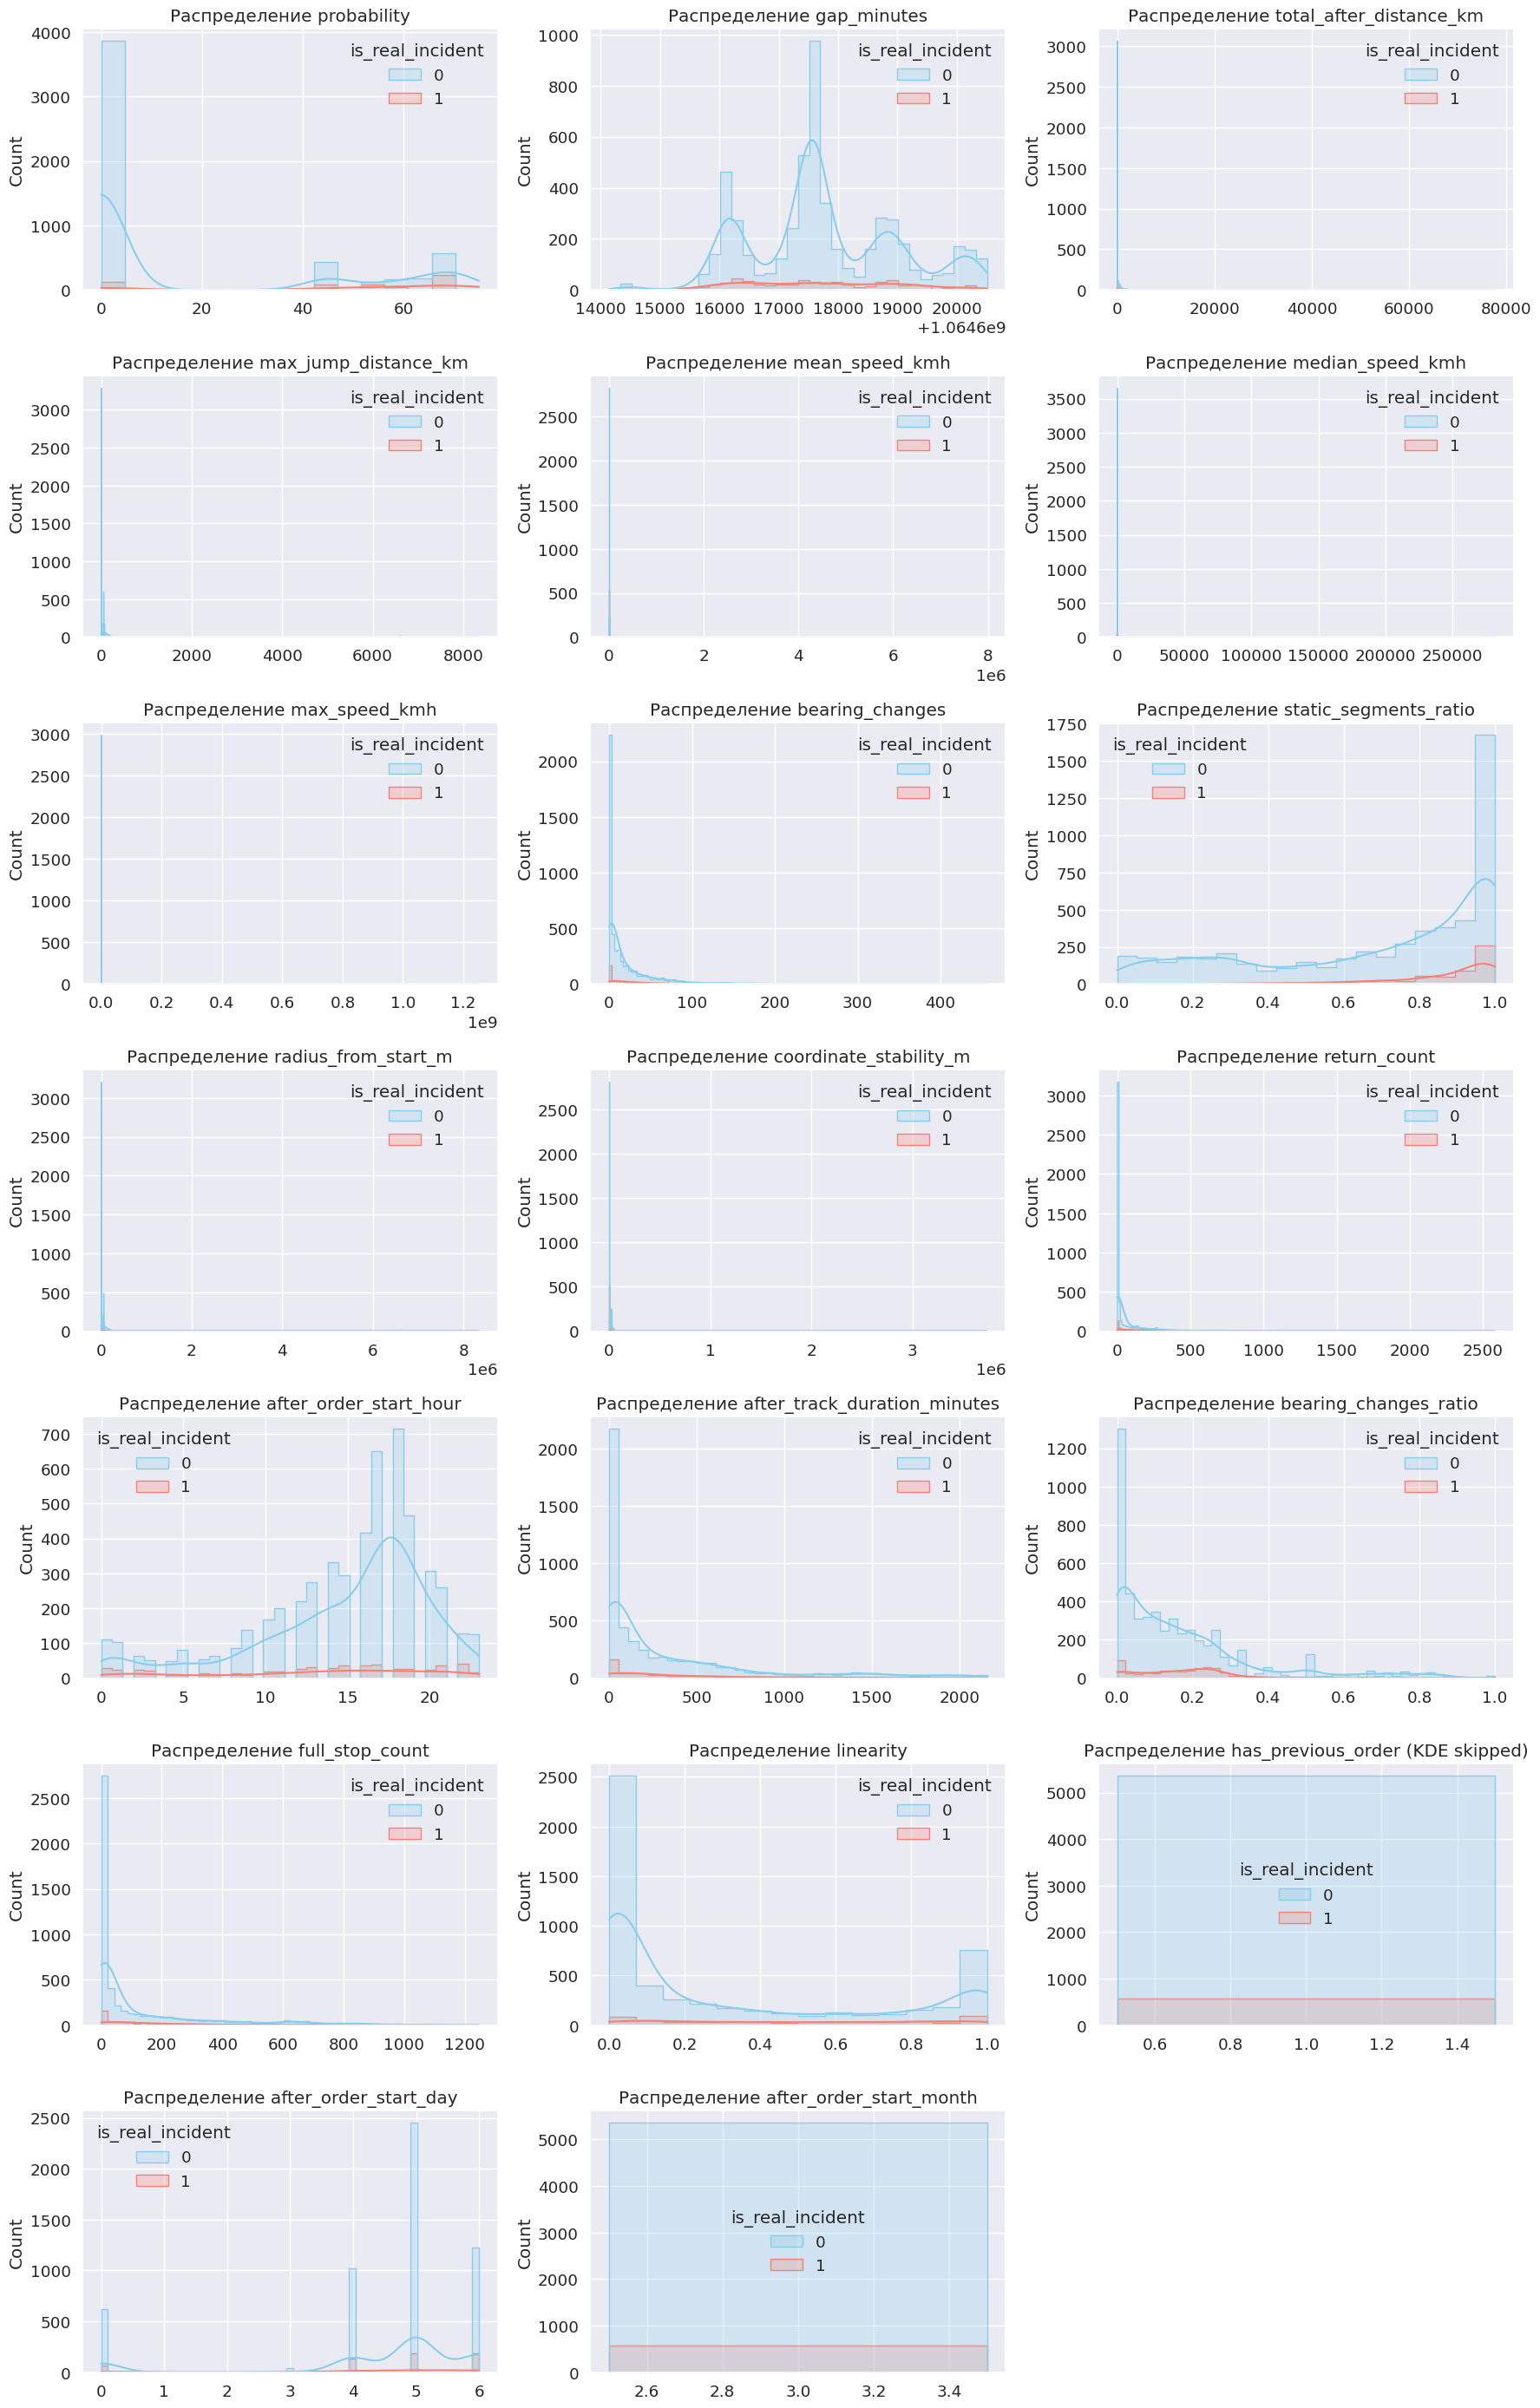

In [ ]:
# 5. Анализ распределений признаков
print("\n5. Анализ распределений признаков")

# Функция для построения гистограмм распределений признаков
def plot_distributions(dataframe, n_cols=3, exclude_cols=None):
    if exclude_cols is None:
        exclude_cols = []

    # Выбираем только числовые признаки, не являющиеся целевыми
    num_features = [col for col in dataframe.select_dtypes(include=['number']).columns
                    if col not in exclude_cols]

    n_rows = int(np.ceil(len(num_features) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
    axes = axes.flatten()

    for i, feature in enumerate(num_features):
        try:
            # Создаем гистограмму с разделением по целевой переменной
            ax = axes[i]
            sns.histplot(data=dataframe, x=feature, hue='is_real_incident',
                         kde=True, element="step", ax=ax, palette=['skyblue', 'salmon'])
            ax.set_title(f'Распределение {feature}')
            ax.set_xlabel('')
        except np.linalg.LinAlgError as e:
            print(f"Error processing feature: {feature}") # Print problematic feature
            print(e)  # Print the error message
            # Optionally, you could continue without KDE for this feature:
            sns.histplot(data=dataframe, x=feature, hue='is_real_incident',
                         element="step", ax=ax, palette=['skyblue', 'salmon'])
            ax.set_title(f'Распределение {feature} (KDE skipped)')
            ax.set_xlabel('')

    # Скрываем неиспользованные оси
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Визуализация распределений числовых признаков
exclude_from_plots = ['incident_id', 'is_real_incident']
print("Визуализация распределений числовых признаков:")
plot_distributions(df, exclude_cols=exclude_from_plots)



6. Обнаружение и обработка выбросов
Box plots для обнаружения выбросов:


<ipython-input-28-e4f253e203e7>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=dataframe, x='is_real_incident', y=feature, ax=ax, palette=['skyblue', 'salmon'])
<ipython-input-28-e4f253e203e7>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=dataframe, x='is_real_incident', y=feature, ax=ax, palette=['skyblue', 'salmon'])
<ipython-input-28-e4f253e203e7>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=dataframe, x='is_real_incident', y=feature, ax=ax, palette=['skyblue', 'salmon'])
<ipython-input-28-e4f253e203e7>:20: Futu

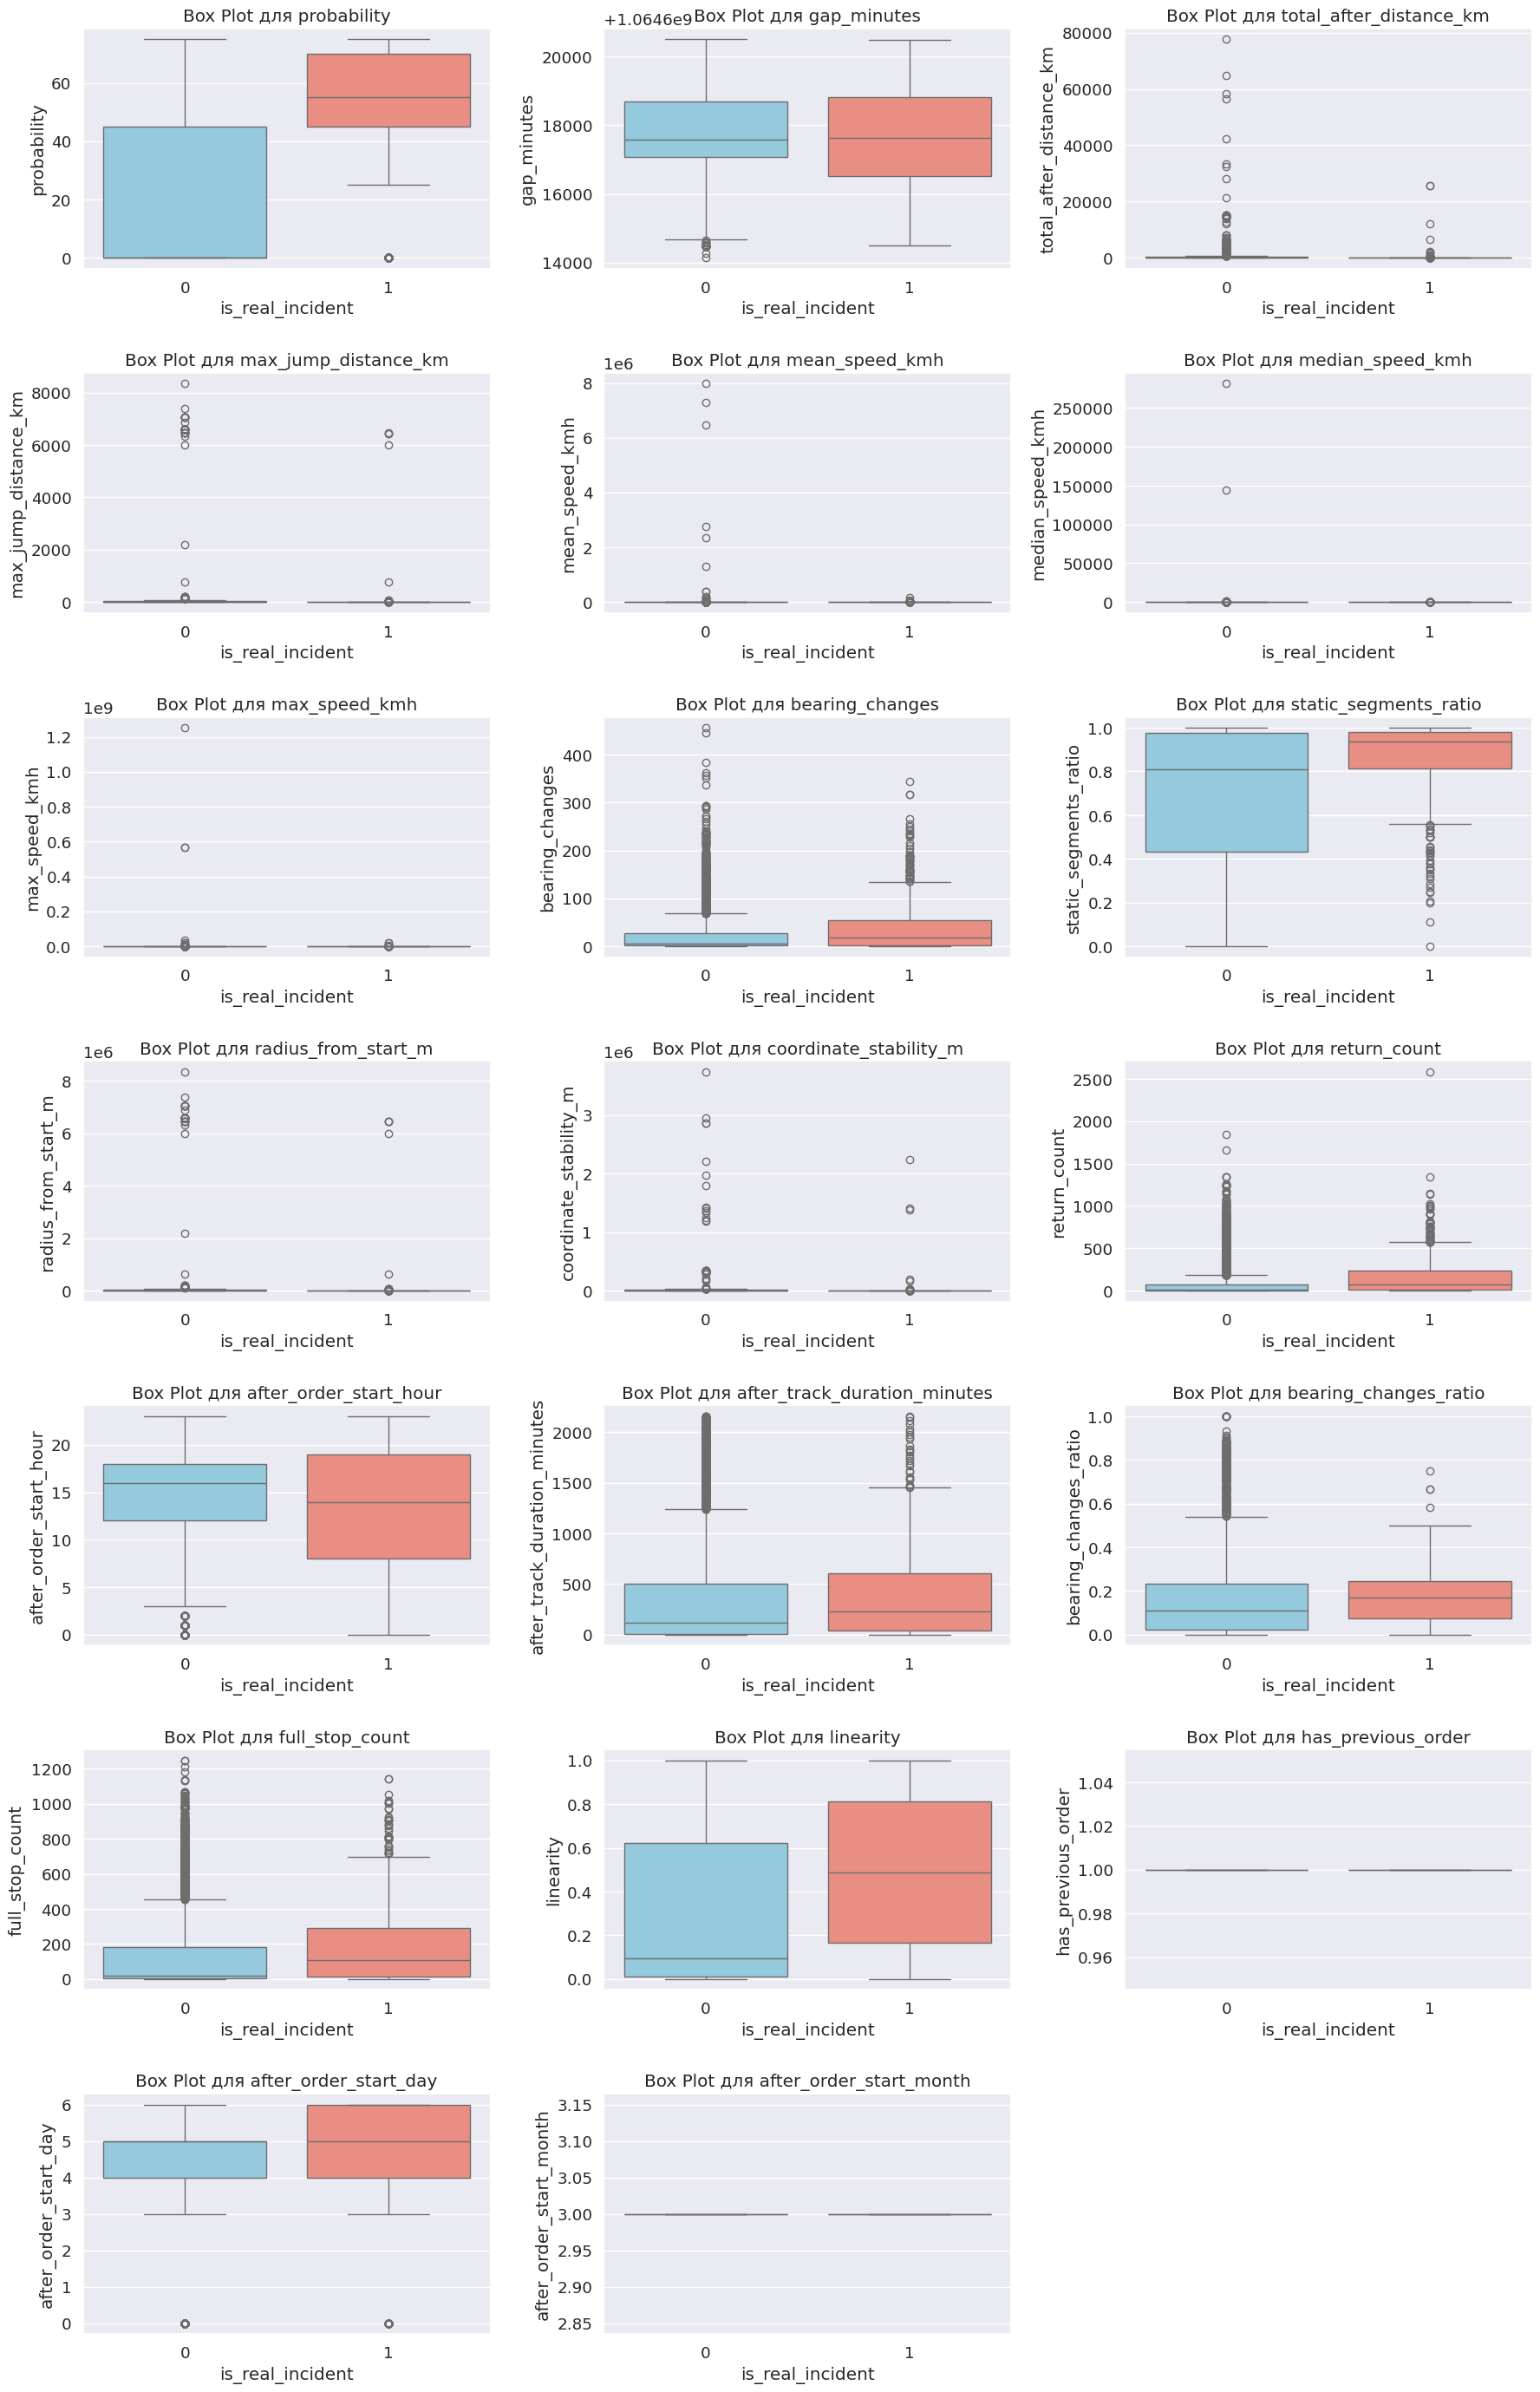

In [ ]:
# 6. Обнаружение и обработка выбросов
print("\n6. Обнаружение и обработка выбросов")

# Функция для построения box plots для обнаружения выбросов
def plot_boxplots(dataframe, n_cols=3, exclude_cols=None):
    if exclude_cols is None:
        exclude_cols = []

    # Выбираем только числовые признаки, не являющиеся целевыми
    num_features = [col for col in dataframe.select_dtypes(include=['number']).columns
                    if col not in exclude_cols]

    n_rows = int(np.ceil(len(num_features) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
    axes = axes.flatten()

    for i, feature in enumerate(num_features):
        # Создаем box plot с разделением по целевой переменной
        ax = axes[i]
        sns.boxplot(data=dataframe, x='is_real_incident', y=feature, ax=ax, palette=['skyblue', 'salmon'])
        ax.set_title(f'Box Plot для {feature}')
        ax.set_xlabel('is_real_incident')

    # Скрываем неиспользованные оси
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Визуализация боксплотов для выявления выбросов
print("Box plots для обнаружения выбросов:")
plot_boxplots(df, exclude_cols=exclude_from_plots)



In [ ]:
# Функция для обработки выбросов с использованием IQR
def handle_outliers(dataframe, columns):
    df_cleaned = dataframe.copy()

    for column in columns:
        Q1 = df_cleaned[column].quantile(0.25)
        Q3 = df_cleaned[column].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Подсчитываем количество выбросов
        outliers_count = ((df_cleaned[column] < lower_bound) | (df_cleaned[column] > upper_bound)).sum()
        outliers_percent = outliers_count / len(df_cleaned) * 100

        print(f"Признак {column}: обнаружено {outliers_count} выбросов ({outliers_percent:.2f}%)")

        # Ограничиваем значения выбросов верхней и нижней границей
        df_cleaned[column] = df_cleaned[column].clip(lower=lower_bound, upper=upper_bound)

    return df_cleaned

# Применяем обработку выбросов к числовым признакам, исключая ID и целевую переменную
numeric_features = df.select_dtypes(include=['number']).columns.tolist()
cols_for_outlier_detection = [col for col in numeric_features if col not in ['incident_id', 'is_real_incident']]



In [ ]:
print("\nОбработка выбросов с использованием метода IQR:")
df_cleaned = handle_outliers(df, cols_for_outlier_detection)


Обработка выбросов с использованием метода IQR:
Признак probability: обнаружено 0 выбросов (0.00%)
Признак gap_minutes: обнаружено 2 выбросов (0.03%)
Признак total_after_distance_km: обнаружено 1077 выбросов (18.14%)
Признак max_jump_distance_km: обнаружено 63 выбросов (1.06%)
Признак mean_speed_kmh: обнаружено 799 выбросов (13.46%)
Признак median_speed_kmh: обнаружено 1422 выбросов (23.95%)
Признак max_speed_kmh: обнаружено 394 выбросов (6.64%)
Признак bearing_changes: обнаружено 569 выбросов (9.58%)
Признак static_segments_ratio: обнаружено 0 выбросов (0.00%)
Признак radius_from_start_m: обнаружено 63 выбросов (1.06%)
Признак coordinate_stability_m: обнаружено 212 выбросов (3.57%)
Признак return_count: обнаружено 837 выбросов (14.10%)
Признак after_order_start_hour: обнаружено 357 выбросов (6.01%)
Признак after_track_duration_minutes: обнаружено 534 выбросов (8.99%)
Признак bearing_changes_ratio: обнаружено 338 выбросов (5.69%)
Признак full_stop_count: обнаружено 618 выбросов (10.41


7. Анализ корреляций между признаками


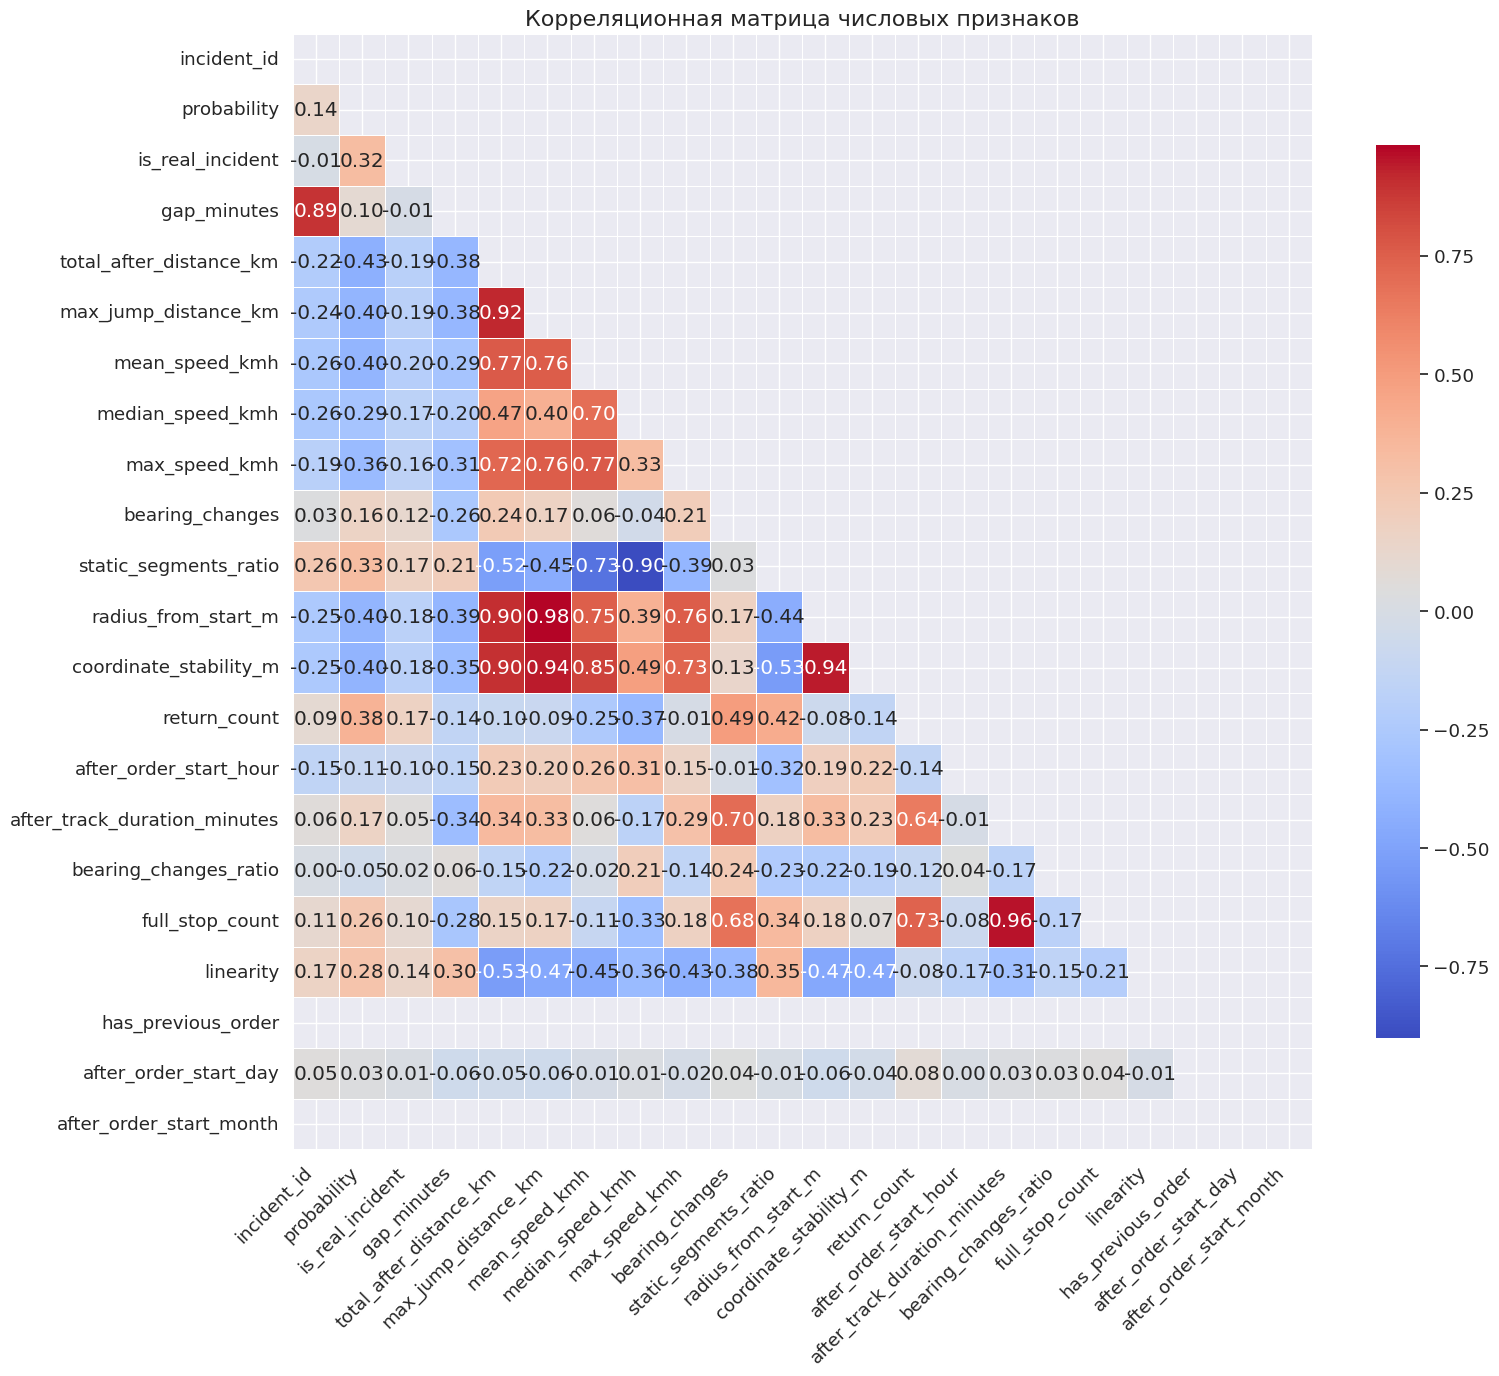

In [ ]:
# 7. Анализ корреляций
print("\n7. Анализ корреляций между признаками")

# Построение корреляционной матрицы
plt.figure(figsize=(16, 14))

correlation_matrix = df_cleaned.select_dtypes(include=['number']).corr()

mask = np.triu(correlation_matrix)
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            mask=mask, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Корреляционная матрица числовых признаков', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


8. Анализ связи признаков с целевой переменной

Корреляция признаков с целевой переменной:
is_real_incident                1.000000
probability                     0.321676
return_count                    0.168524
static_segments_ratio           0.167060
linearity                       0.141641
bearing_changes                 0.118450
full_stop_count                 0.102139
after_track_duration_minutes    0.053548
bearing_changes_ratio           0.018487
after_order_start_day           0.011118
incident_id                    -0.005694
gap_minutes                    -0.012348
after_order_start_hour         -0.098395
max_speed_kmh                  -0.163174
median_speed_kmh               -0.167648
radius_from_start_m            -0.176633
coordinate_stability_m         -0.183798
max_jump_distance_km           -0.185964
total_after_distance_km        -0.191103
mean_speed_kmh                 -0.201764
has_previous_order                   NaN
after_order_start_month              NaN
Name: 

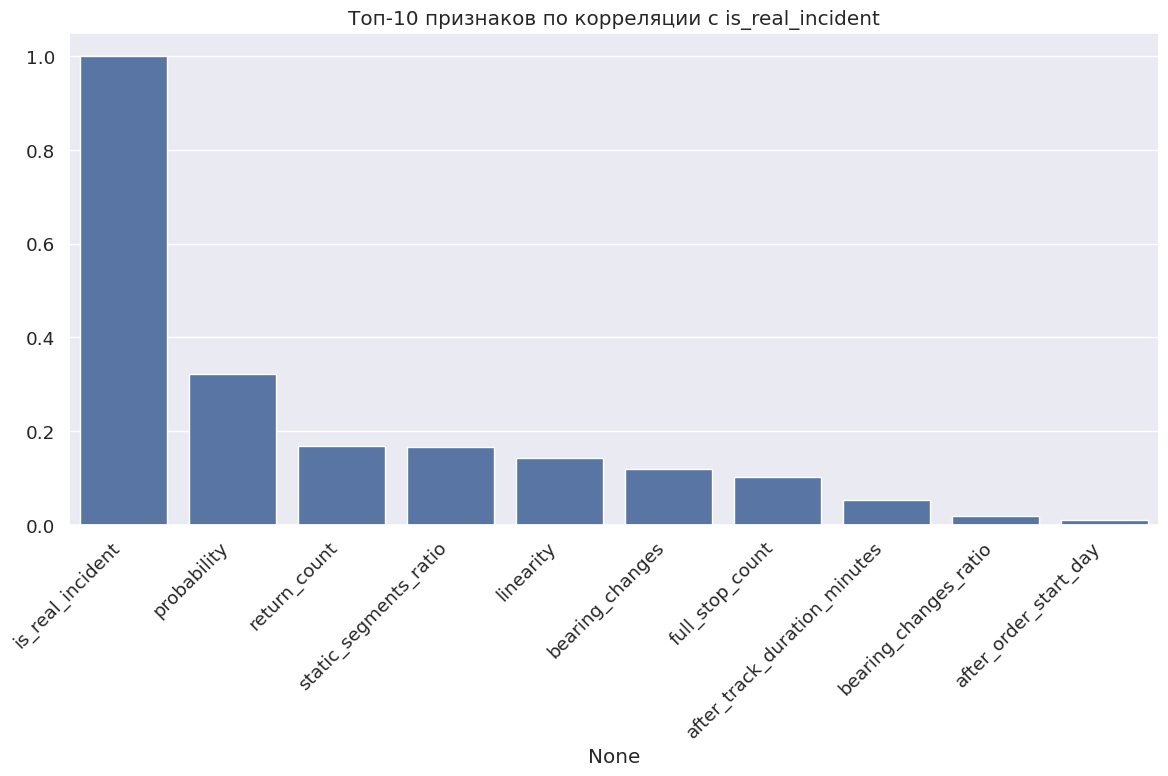

In [ ]:
# 8. Связь признаков с целевой переменной
print("\n8. Анализ связи признаков с целевой переменной")

# Расчет корреляции признаков с целевой переменной
target_correlation = correlation_matrix['is_real_incident'].sort_values(ascending=False)
print("\nКорреляция признаков с целевой переменной:")
print(target_correlation)

# Визуализация топ-10 признаков по корреляции с целевой переменной
plt.figure(figsize=(12, 8))
sns.barplot(x=target_correlation.index[:10], y=target_correlation.values[:10])
plt.title('Топ-10 признаков по корреляции с is_real_incident')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



9. Изучение зависимостей между признаками
Построение scatter matrix для топ-5 признаков: ['probability', 'return_count', 'static_segments_ratio', 'linearity', 'bearing_changes']


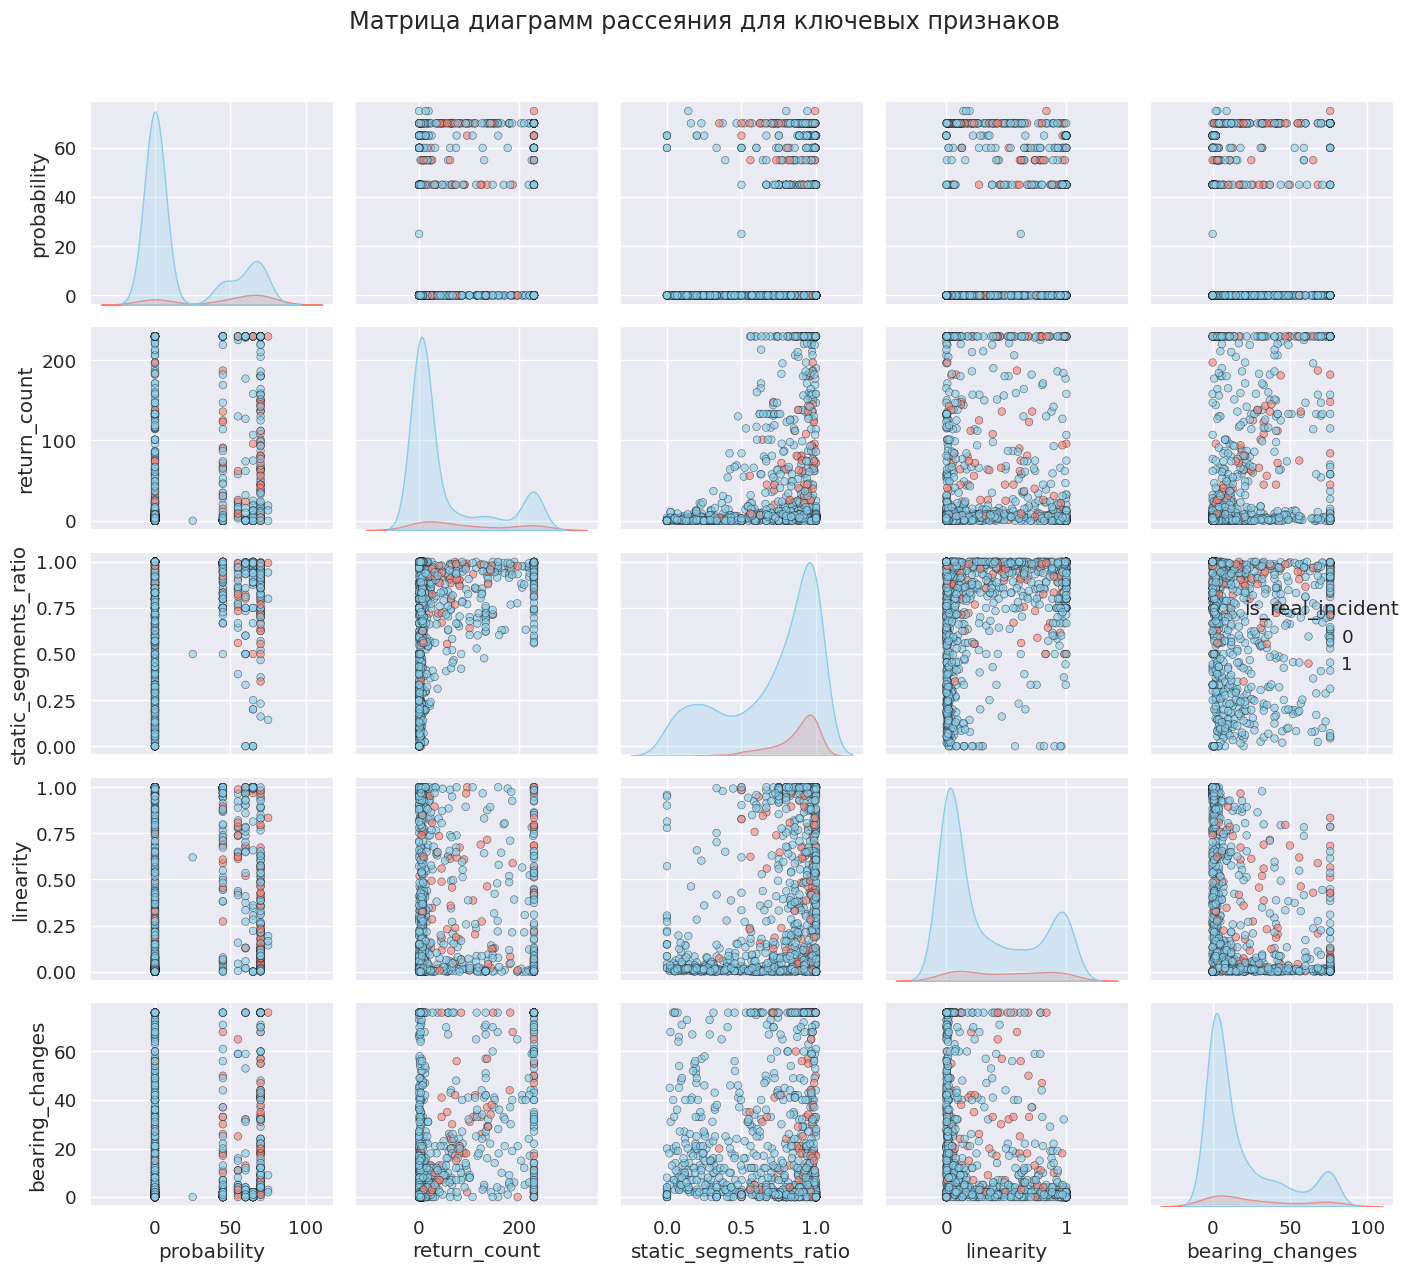

In [ ]:
# 9. Изучение зависимостей между признаками
print("\n9. Изучение зависимостей между признаками")

# Функция для построения scatter plots для пар признаков
def plot_scatter_matrix(dataframe, features, target_col='is_real_incident'):
    # Создаем подвыборку данных для более быстрой визуализации
    if len(dataframe) > 1000:
        sample_df = dataframe.sample(1000, random_state=42)
    else:
        sample_df = dataframe

    # Создаем pairplot для выбранных признаков
    sns.pairplot(data=sample_df, vars=features, hue=target_col, diag_kind='kde',
                palette=['skyblue', 'salmon'], plot_kws={'alpha': 0.6, 's': 30, 'edgecolor': 'k'})
    plt.suptitle('Матрица диаграмм рассеяния для ключевых признаков', y=1.02)
    plt.tight_layout()
    plt.show()

# Выбираем топ-5 признаков с наибольшей корреляцией с целевой переменной (кроме самой цели)
top_features = [col for col in target_correlation.index if col != 'is_real_incident'][:5]
print(f"Построение scatter matrix для топ-5 признаков: {top_features}")
plot_scatter_matrix(df_cleaned, top_features)

In [ ]:
# 10. Трансформация и масштабирование признаков
print("\n10. Трансформация и масштабирование признаков")

# Функция для логарифмического преобразования признаков с асимметричным распределением
def log_transform_features(dataframe, features):
    df_transformed = dataframe.copy()

    for feature in features:
        # Проверка на наличие отрицательных или нулевых значений
        min_value = df_transformed[feature].min()

        if min_value <= 0:
            # Добавляем константу, чтобы все значения были положительными
            shift = abs(min_value) + 1
            df_transformed[f'{feature}_log'] = np.log1p(df_transformed[feature] + shift)
            print(f"Применено log-преобразование к {feature} с добавлением константы {shift}")
        else:
            df_transformed[f'{feature}_log'] = np.log1p(df_transformed[feature])
            print(f"Применено log-преобразование к {feature}")

    return df_transformed

# Выбираем признаки с асимметричным распределением для логарифмирования
skewed_features = ['total_after_distance_km', 'max_jump_distance_km', 'max_speed_kmh',
                  'radius_from_start_m', 'coordinate_stability_m']
print("Применение логарифмического преобразования к признакам с асимметричным распределением:")
df_transformed = log_transform_features(df_cleaned, skewed_features)




10. Трансформация и масштабирование признаков
Применение логарифмического преобразования к признакам с асимметричным распределением:
Применено log-преобразование к total_after_distance_km с добавлением константы 1.0
Применено log-преобразование к max_jump_distance_km с добавлением константы 1.0
Применено log-преобразование к max_speed_kmh с добавлением константы 1.0
Применено log-преобразование к radius_from_start_m с добавлением константы 1.0
Применено log-преобразование к coordinate_stability_m с добавлением константы 1.0


In [ ]:
# Функция для масштабирования признаков
def scale_features(dataframe, features, scaler_type='standard'):
    df_scaled = dataframe.copy()

    if scaler_type == 'standard':
        scaler = StandardScaler()
        suffix = '_scaled'
    elif scaler_type == 'minmax':
        scaler = MinMaxScaler()
        suffix = '_norm'
    else:
        raise ValueError("Неподдерживаемый тип масштабирования. Используйте 'standard' или 'minmax'.")

    # Масштабируем выбранные признаки
    scaled_features = scaler.fit_transform(df_scaled[features])

    # Добавляем масштабированные признаки в датафрейм
    for i, feature in enumerate(features):
        df_scaled[f'{feature}{suffix}'] = scaled_features[:, i]

    return df_scaled, scaler

# Выбираем числовые признаки для масштабирования (исключая ID и целевую переменную)
features_to_scale = [col for col in df_transformed.select_dtypes(include=['number']).columns
                    if col not in ['incident_id', 'is_real_incident']]



In [ ]:
print("\nПрименение StandardScaler для масштабирования признаков:")
df_scaled, std_scaler = scale_features(df_transformed, features_to_scale, 'standard')




Применение StandardScaler для масштабирования признаков:


In [ ]:
print("\nПрименение MinMaxScaler для нормализации признаков:")
df_normalized, minmax_scaler = scale_features(df_transformed, features_to_scale, 'minmax')


Применение MinMaxScaler для нормализации признаков:


In [ ]:
# 11. Выделение признаков с помощью feature importance
print("\n11. Оценка важности признаков")

# Подготовка данных для обучения модели
X = df_cleaned.drop(['incident_id', 'is_real_incident', 'last_order_end', 'after_order_start'], axis=1)
y = df_cleaned['is_real_incident']

# Оценка важности признаков с помощью SelectKBest
print("\nОценка важности признаков с помощью SelectKBest (f_classif):")
selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X, y)

# Создаем DataFrame с оценками важности признаков
feature_scores = pd.DataFrame({
    'Feature': X.columns,
    'Score': selector.scores_,
    'P-value': selector.pvalues_
})
feature_scores = feature_scores.sort_values('Score', ascending=False)
print(feature_scores)

# Визуализация оценок важности признаков
plt.figure(figsize=(12, 8))
sns.barplot(x='Score', y='Feature', data=feature_scores.head(15))
plt.title('Топ-15 признаков по важности (f_classif)')
plt.tight_layout()
plt.show()


In [ ]:
# Оценка важности признаков с помощью RandomForest
print("\nОценка важности признаков с помощью RandomForest:")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X, y)

# Создаем DataFrame с оценками важности признаков из RandomForest
rf_feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
})
rf_feature_importance = rf_feature_importance.sort_values('Importance', ascending=False)
print(rf_feature_importance)

# Визуализация оценок важности признаков от RandomForest
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=rf_feature_importance.head(15))
plt.title('Топ-15 признаков по важности (RandomForest)')
plt.tight_layout()
plt.show()

In [ ]:
# 12. Выводы по EDA и рекомендации
print("\n12. Основные выводы по EDA и рекомендации")

print("""
Основные выводы по результатам EDA:

1. Распределение целевой переменной:
   - Представлено распределение классов (реальные/ложные тревоги)
   - Важно учитывать дисбаланс классов при обучении модели (если он есть)

2. Обнаружены аномалии в данных:
   - Некорректные даты (0001-01-01) в столбце last_order_end
   - Выбросы в нескольких числовых признаках

3. Важные закономерности:
   - Выявлены признаки, имеющие наибольшую корреляцию с целевой переменной
   - Обнаружены взаимозависимости между некоторыми признаками

4. Трансформации данных:
   - Применены логарифмические преобразования к признакам с асимметричным распределением
   - Выполнено масштабирование признаков

5. Определены наиболее важные признаки для предсказания реальных тревог

Рекомендации для построения модели:

1. Использовать выделенные важные признаки
2. Учитывать дисбаланс классов (если есть)
3. Протестировать различные алгоритмы классификации
4. Провести тщательную кросс-валидацию модели
5. Оценить результаты с использованием метрик, соответствующих бизнес-задаче
   (например, точность, полнота, F1-мера, ROC-AUC)
""")

